In [42]:
import numpy as np
import matplotlib.pyplot as plt
import gvar as gv
from tqdm import tqdm
rng = np.random.default_rng()

In [62]:
J = 1
nmax = 40
N = nmax**2

In [3]:
def build_lattice(n=0,m=0):    
    #lattice = rng.choice(spin_select, (n,m), p =[0.5,0.5])    
    return rng.choice([-1,1], (nmax,nmax), p =[0.5,0.5])

In [4]:
def Energy(lattice:np.ndarray)->float:
    spin_bonds = 0
    for i in range(nmax):
        for j in range(nmax):
            s_ij = lattice[i,j]
            if j<nmax-1:
                s_right = lattice[i, j+1] #right neighbor
            else:
                s_right = 0 #right edge of lattice
            if i<nmax-1:
                s_down = lattice[i+1,j] #bottom neighbor
            else:
                s_down = 0 # bottom edge of lattice
            spin_bonds += s_ij * (s_right + s_down)
    
    E = (-J) * spin_bonds/N
    return E

In [5]:
def new_energy(lattice:np.ndarray)->float:
    return -J/N * ( np.sum( lattice[0:nmax-1,:] * lattice[1:nmax,:] ) + np.sum( lattice[:,0:nmax-1] * lattice[:,1:nmax] ) )

In [6]:
def flip_energy(lattice:np.ndarray, flip_location:tuple)->float:
    i,j = flip_location
    s_ij = lattice[i,j]
    
    s_up = lattice[abs(i-1),j] * (i!=0)
    s_down = lattice[(i+1)%nmax,j] * (i!=nmax)   
    s_left = lattice[i,abs(j-1)] * (j!=0)
    s_right = lattice[i,(j+1)%nmax] * (j!=nmax)
   
    neighbors = (s_up + s_down + s_left + s_right)
    flipped_sum = -1 * s_ij * neighbors  # flips the spin
    initial_sum = s_ij * neighbors
    return (-J) * (flipped_sum - initial_sum) /N

In [7]:
def magnetization(lattice:np.ndarray)->float:
    return lattice.sum()/N

In [57]:
for a in range(5):
    print(a)
    #print(b)

0
1
2
3
4


In [53]:
range(5,2)

range(5, 2)

In [59]:
def spin_corr(lattice:np.ndarray)->float:
    si = magnetization(lattice)
    sisj = []
    dist = []
    for xi in range(len(lattice)):
        for yi in range(len(lattice)):
            #sisj = 0
            for xj in range(len(lattice)):
                for yj in range(len(lattice)):
                    distance = np.sqrt((xi-xj)**2 + (yi-yj)**2)
                    if distance>0: 
                        dist.append(distance)
                        sisj.append(lattice[xi,yi] * lattice[xj,yj])
                        
        # need to average sisj, but not sure how to get distances to be relevant
    return dist, sisj
    #return sisj/N - si**2  # averages <Sij * Sab> over whole array... returns 1 value per MC step, probably wrong.

In [61]:
spin_corr(build_lattice())

([1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  1.0,
  1.4142135623730951,
  2.23606797749979,
  3.1622776601683795,
  4.123105625617661,
  5.0990195135927845,
  6.082762530298219,
  7.0710678118654755,
  8.06225774829855,
  9.055385138137417,
  2.0,
  2.23606797749979,
  2.8284271247461903,
  3.605551275463989,
  4.47213595499958,
  5.385164807134504,
  6.324555320336759,
  7.280109889280518,
  8.246211251235321,
  9.219544457292887,
  3.0,
  3.1622776601683795,
  3.605551275463989,
  4.242640687119285,
  5.0,
  5.830951894845301,
  6.708203932499369,
  7.615773105863909,
  8.54400374531753,
  9.486832980505138,
  4.0,
  4.123105625617661,
  4.47213595499958,
  5.0,
  5.656854249492381,
  6.4031242374328485,
  7.211102550927978,
  8.06225774829855,
  8.94427190999916,
  9.848857801796104,
  5.0,
  5.0990195135927845,
  5.385164807134504,
  5.830951894845301,
  6.4031242374328485,
  7.0710678118654755,
  7.810249675906654,
  8.602325267042627,
  9.433981132056603,
  10

In [8]:
def mcmc(lattice, beta, nflips, nsteps):
    lattice = lattice.copy()
    energy = Energy(lattice)
    av_energy = np.zeros(nsteps)
    av_mag = np.zeros(nsteps)
    for step in range(nsteps):
        for flip in range(nflips):
            flip_location = tuple(rng.integers(len(lattice),size=2))
            flip_dE = flip_energy(lattice,flip_location)
            if (np.exp(-beta*flip_dE)>rng.random()):
                lattice[flip_location] = -1 * lattice[flip_location]
                energy += flip_dE              
        # record energy and magnetization
        av_energy[step] = energy
        av_mag[step] = magnetization(lattice)
        
    return av_energy, av_mag

In [9]:
def wolff(lattice, beta):
    N = len(lattice)
    i, j = rng.integers(N), rng.integers(N)
    S = lattice[i,j]
    C = [[i,j]]
    F_old = [[i,j]]
    p_accept = 1. - np.exp(-2 * beta)
    while len(F_old) > 0:
        F_new = []
        for i,j in F_old:
            neighbours = [[(i+1) % N,j], [(i-1+N) % N,j], [i,(j+1) % N], [i,(j-1+N) % N]]
            for neighbour in neighbours:
                if lattice[neighbour[0],neighbour[1]] == S and neighbour not in C:
                    if rng.random() < p_accept:
                        F_new.append(neighbour)
                        C.append(neighbour)
        F_old = F_new
    for i,j in C:
        lattice[i,j] *= -1

In [10]:
def imported_wolff(lattice,beta,nsteps):
    measure_step = 100
    av_energy = np.zeros(int(nsteps/measure_step))
    av_mag = np.zeros(int(nsteps/measure_step))
    for i in range(nsteps):
        wolff(lattice,beta)
        if i%measure_step ==0:
            av_energy[int(i/measure_step)]=new_energy(lattice)
            av_mag[int(i/measure_step)]=magnetization(lattice)
            #print((i/measure_step)/nsteps)
    return av_energy, av_mag
    #return av_mag

In [11]:
ew,mw = imported_wolff(build_lattice(), 0.30, 10**4)

In [50]:
observables = {'Energy':ew,'M':mw, "M2":mw**2}
obs_average = gv.dataset.avg_data(observables)
corr = gv.evalcorr(obs_average)

In [106]:
mw.std()/30

0.004700194735918455

In [108]:
ew.std()/30

0.003546442270470193

In [20]:
gv.dataset.autocorr(ew)

array([ 1.00000000e+00,  7.05721120e-01,  5.05160700e-01,  3.66424127e-01,
        2.48009836e-01,  1.58553513e-01,  8.88167169e-02,  7.13910880e-02,
        7.19767034e-02,  6.74146166e-02,  6.31524791e-02,  4.81435849e-02,
        6.11013969e-02,  5.38683325e-02,  4.23702740e-02,  2.89182598e-02,
        2.15652157e-02,  2.50503415e-02,  3.63884270e-02,  3.54400157e-02,
        3.44573245e-02,  4.43727931e-02,  5.97387698e-02,  4.95119253e-02,
        3.59713546e-02,  2.27450165e-02,  1.12412447e-02,  1.61604141e-02,
        1.84657391e-02, -2.23933616e-03, -5.30167620e-03, -1.77195794e-02,
       -3.28513100e-02, -2.16874808e-02, -8.81822527e-03, -1.85080176e-02,
       -2.77693110e-02, -3.06316848e-02, -4.04528835e-02, -1.48086423e-02,
       -2.64212529e-03,  3.46541484e-03,  4.35557882e-02,  4.97176048e-02,
        4.04820215e-02,  2.71042804e-02, -2.35931590e-03, -3.41625171e-02,
       -3.53394613e-02, -4.31609977e-02, -4.57434188e-02, -4.35523602e-02,
       -1.59741598e-02, -

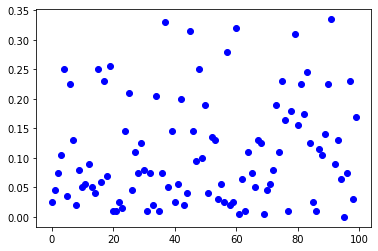

In [107]:
plt.plot(np.arange(len(mw)),np.abs(mw),'bo')

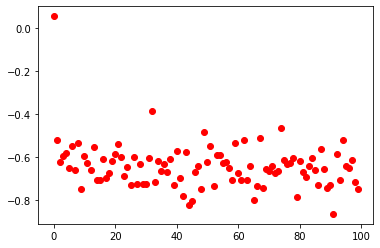

In [109]:
plt.plot(np.arange(len(ew)),(ew),'ro')

In [46]:
def temp_wolff():
    beta = np.linspace(0.41,0.45,40)
    e_list = np.zeros(len(beta))
    m_list = np.zeros(len(beta))
    chi_list = np.zeros(len(beta))
    for i in tqdm(range(len(beta))):
        e,m = imported_wolff(build_lattice(),beta[i],10**4)
        e_list[i] = np.mean(e)
        m_list[i] = np.mean(np.abs(m))
        chi_list[i] = np.mean(m**2) - m_list[i]**2
        
    return e_list,m_list,chi_list

In [14]:
et, mt, ct = temp_wolff()

In [48]:
et40, mt40, ct40 = temp_wolff()

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [1:25:49<00:00, 128.74s/it]


In [23]:
et50,mt50,ct50 = temp_wolff()

In [44]:
et65,mt65,ct65 = temp_wolff()

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:45:30<00:00, 316.51s/it]


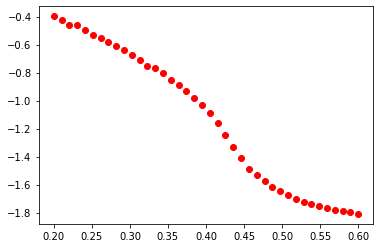

In [91]:
plt.plot(np.linspace(0.2,0.6,40),et,'ro')

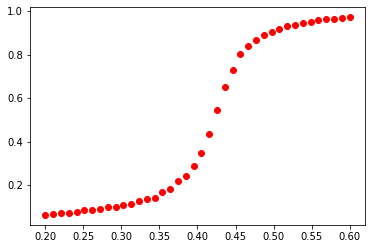

In [93]:
plt.plot(np.linspace(0.2,0.6,40),np.abs(mt),'ro')

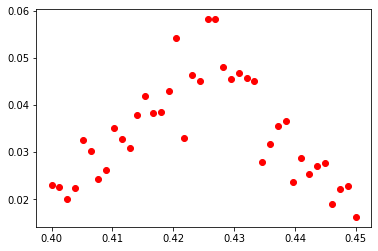

In [15]:
plt.plot(np.linspace(0.4,0.45,40),ct,'ro') #30 x 30 lattice

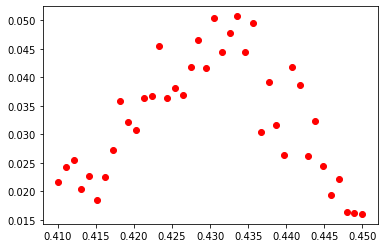

In [49]:
plt.plot(np.linspace(0.41,0.45,40),ct40,'ro')

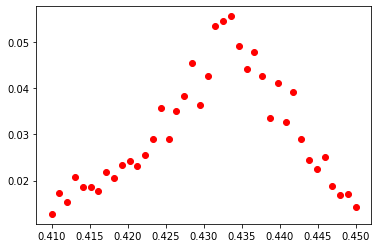

In [24]:
plt.plot(np.linspace(0.41,0.45,40),ct50,'ro')

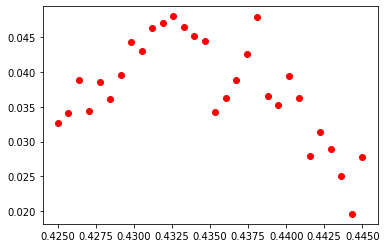

In [33]:
plt.plot(np.linspace(0.425,0.445,30),ct65,'ro')

In [ ]:
5

(0.428, 0.442)

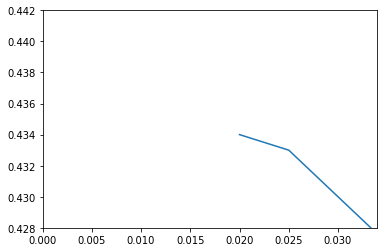

In [28]:
plt.plot([1/50,1/40,1/30],[.434, .433, .4280])
plt.xlim([0,.034])
plt.ylim([.428,.442])

In [ ]:
def mc_wolff(lattice, beta, nsteps):
    lattice = lattice.copy()
    p_accept = 1.0 - np.exp(-2*beta)
    for n in range(nsteps):        
        i,j = tuple(rng.integers(len(lattice), size = 2))
        init_spin = lattice[i,j]
        cluster = np.array([])
        while 1:
            if lattice[i-1,j]==init_spin and not np.any(